In [4]:
tqdm.pandas()

In [1]:
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import seaborn as sns
from scipy.stats import iqr
import useful_rdkit_utils as uru
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import polaris as po

In [23]:
tqdm.pandas()

In [24]:
def prepare_dataset(df,smiles_col):
    df.rename(columns={smiles_col : "SMILES"}, inplace=True)
    df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)
    num_before = len(df)
    df.dropna(subset="mol",inplace=True)
    num_after = len(df)
    delta = num_before - num_after
    if delta > 0:
        print(f"Removed {delta} bad records")
    fpgen = rdFingerprintGenerator.GetMorganGenerator()
    df['morgan'] = df.mol.progress_apply(fpgen.GetFingerprint)
    descgen = uru.RDKitDescriptors(skip_fragments=True)
    df['desc'] = df.mol.progress_apply(descgen.calc_mol)

In [25]:
def find_most_similar(df_test, df_train):
    sim_list = []
    for fp in tqdm(df_test.morgan):
        sims = DataStructs.BulkTanimotoSimilarity(fp,df_train.morgan.values)
        sim_list.append(max(sims))
    df_test['most_similar'] = sim_list

In [26]:
prepare_dataset(df_train,"SMILES")

  0%|          | 0/17935 [00:00<?, ?it/s]

[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors
[19:36:56] WARNING: not removing hydrogen atom without neighbors


  0%|          | 0/17935 [00:00<?, ?it/s]

  0%|          | 0/17935 [00:00<?, ?it/s]

In [27]:
df_train

,Unnamed: 0,C_ID,Name,InChIKey,SMILES,CAS,LogS,smiles_canon,mol,morgan,desc
0,0,A-51,NaN,BOCJQSFSGAZAPQ-UHFFFAOYSA-N,Clc1c2C(=O)c3c(C(=O)c2ccc1)cccc3,NaN,-5.540000,O=C1c2ccccc2C(=O)c2c(Cl)cccc21,<rdkit.Chem.rdchem.Mol object at 0x16a3afe60>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.35654008815082, 2.3004926509341947, -2.1724..."
1,1,A-53,NaN,BRBKOPJOKNSWSG-UHFFFAOYSA-N,S(=O)(=O)(N=C(N)N)c1ccc(N)cc1,NaN,-1.984970,NC(N)=NS(=O)(=O)c1ccc(N)cc1,<rdkit.Chem.rdchem.Mol object at 0x16a3afd80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.0192017449044513, 2.1137849687703674, -1.98..."
2,2,A-55,NaN,BRPOVUNVTUCYNN-UHFFFAOYSA-N,Fc1c(N2C(CC)C(N)C2)cc2n(C3CC3)cc(C(=O)O)c(=O)c2c1,NaN,-3.912000,CCC1C(N)CN1c1cc2c(cc1F)c(=O)c(C(=O)O)cn2C1CC1,<rdkit.Chem.rdchem.Mol object at 0x16a3afca0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.378392164942047, 2.3664860949800897, -2.475..."
3,3,A-60,NaN,BWXSXZAIQQSFPW-UHFFFAOYSA-N,O=[N+]([O-])c1cc2C(=O)OC(CC)(CC)c2cc1,NaN,-3.656000,CCC1(CC)OC(=O)c2cc([N+](=O)[O-])ccc21,<rdkit.Chem.rdchem.Mol object at 0x16a3afbc0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.624338410253384, 2.428994056263164, -2.2515..."
4,4,A-68,NaN,CAQHPYSDQFDJAL-UHFFFAOYSA-N,O=C1C(=NO)c2c(cccc2)C=C1,NaN,-2.937000,O=C1C=Cc2ccccc2C1=NO,<rdkit.Chem.rdchem.Mol object at 0x16a3afa70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.1770076732315258, 2.177481783031173, -2.086..."
...,...,...,...,...,...,...,...,...,...,...,...
17932,19115,B-1403,ISO-OXAZOLE,CTAPFRYPJLPFDF-UHFFFAOYSA-N,C1=CON=C1,000288-14-2,0.383095,c1cnoc1,<rdkit.Chem.rdchem.Mol object at 0x1756a2810>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.760495029766198, 1.5989854941663038, -1.479..."
17933,19116,D-4869,fuberidazole,UYJUZNLFJAWNEZ-UHFFFAOYSA-N,[nH]1c2ccccc2nc1c3occc3,003878-19-1,-3.414016,c1coc(-c2nc3ccccc3[nH]2)c1,<rdkit.Chem.rdchem.Mol object at 0x1756a2880>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.8620699835469217, 2.051849740842862, -1.853..."
17934,19117,B-7032,1H-1.2.4-Triazole,NSPMIYGKQJPBQR-UHFFFAOYSA-N,C1=NC=NN1,000288-88-0,0.897170,c1nc[nH]n1,<rdkit.Chem.rdchem.Mol object at 0x1756a28f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.760495029766198, 1.5659533748683938, -1.457..."
17935,19118,D-1643,purine,KDCGOANMDULRCW-UHFFFAOYSA-N,[NH]1C=NC2=C1C=NC=N2,000120-73-0,0.619695,c1ncc2[nH]cnc2n1,<rdkit.Chem.rdchem.Mol object at 0x1756a2960>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.3327430273186147, 1.9061363473416486, -1.79..."


In [14]:
df_train = pd.read_csv("final_unique_train.csv")
df_train['mol'] = df_train.SMILES.progress_apply(Chem.MolFromSmiles)
train_before = len(df_train)
#df_train.dropna(subset="mol",inplace=True)
train_after = len(df_train)
train_before, train_after

  0%|          | 0/17937 [00:00<?, ?it/s]

[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] Explicit valence for atom # 5 N, 4, is greater than permitted
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors
[19:32:47] WARNING: not removing hydrogen atom without neighbors


(17937, 17937)

In [18]:
df_test = pd.read_csv("final_unique_test.csv")
df_test['mol'] = df_test.SMILES.progress_apply(Chem.MolFromSmiles)
test_before = len(df_test)
df_test.dropna(subset="mol",inplace=True)
test_after = len(df_test)
test_before, test_after

  0%|          | 0/1282 [00:00<?, ?it/s]

(1282, 1282)

In [21]:
fpgen = rdFingerprintGenerator.GetMorganGenerator()

In [22]:
df_train['morgan'] = df_train.mol.progress_apply(fpgen.GetFingerprint)
df_test['morgan'] = df_test.mol.progress_apply(fpgen.GetFingerprint)

  0%|          | 0/17935 [00:00<?, ?it/s]

  0%|          | 0/1282 [00:00<?, ?it/s]

In [33]:
sim_list = []
for fp in tqdm(df_test.morgan):
    sims = DataStructs.BulkTanimotoSimilarity(fp,df_train.morgan.values)
    sim_list.append(max(sims))

  0%|          | 0/1282 [00:00<?, ?it/s]

In [68]:
df_test['most_similar'] = sim_list

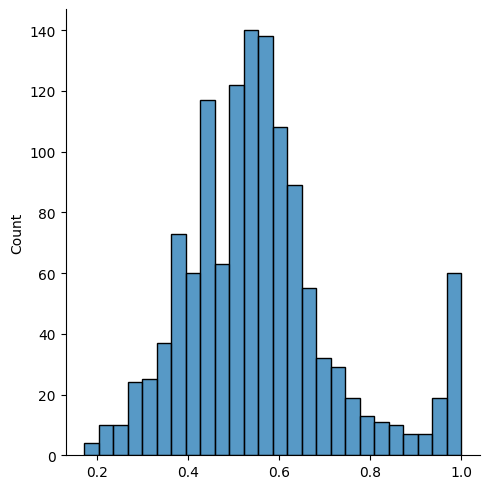

In [37]:
sns.displot(sim_list)

In [38]:
df_train['split'] = 'train'
df_test['split'] = 'test'

<Axes: xlabel='split', ylabel='LogS'>

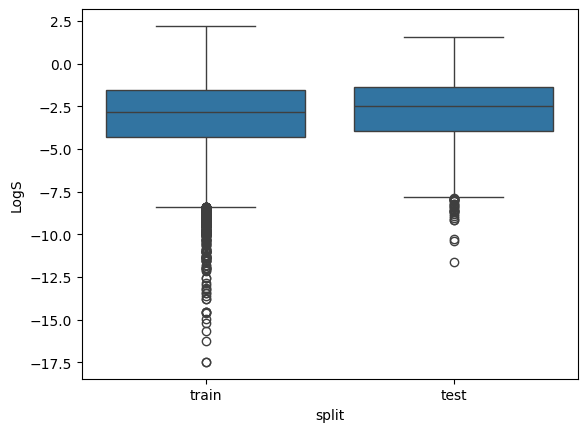

In [40]:
sns.boxplot(x="split",y="LogS",data=pd.concat([df_train,df_test]))

In [46]:
iqr_train = iqr(df_train.LogS)
iqr_test = iqr(df_test.LogS)
f"train_iqr = {iqr_train:.2f} test_iqr = {iqr_test:.2f}"

'train_iqr = 2.75 test_iqr = 2.59'

In [48]:
desc_calc = uru.RDKitDescriptors(skip_fragments=True)

In [49]:
df_train['desc'] = df_train.mol.progress_apply(desc_calc.calc_mol)

  0%|          | 0/17935 [00:00<?, ?it/s]

In [50]:
df_test['desc'] = df_test.mol.progress_apply(desc_calc.calc_mol)

  0%|          | 0/1282 [00:00<?, ?it/s]

In [63]:
xgb = XGBRegressor(learning_rate =0.01,n_estimators=2000,max_depth=8,min_child_weight=4,gamma=0,subsample=0.7,
                                           colsample_bytree=0.8,nthread=2,scale_pos_weight=1,seed=27)

In [64]:
xgb.fit(np.stack(df_train.desc),df_train.LogS)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, nthread=2, ...)

In [70]:
df_test['pred'] = xgb.predict(np.stack(df_test.desc))

In [72]:
r2_score(df_test.LogS,df_test.pred)

0.9237554580027643

In [73]:
mean_absolute_error(df_test.LogS,df_test.pred)

0.41477224137340546

<Axes: xlabel='LogS', ylabel='pred'>

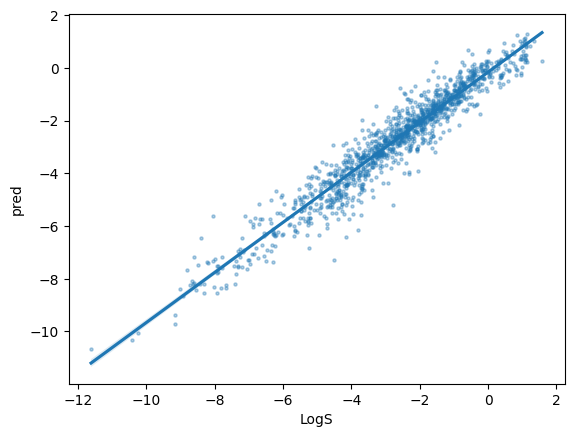

In [132]:
sns.regplot(x="LogS",y="pred",data=df_test,scatter_kws={"s": 5, "alpha" : 0.35})

In [105]:
biogen_df = pd.read_csv("biogen_logS.csv")

In [107]:
biogen_df['mol'] = biogen_df.SMILES.apply(Chem.MolFromSmiles)
biogen_df['morgan'] = biogen_df.mol.progress_apply(fpgen.GetFingerprint)
biogen_df['desc'] = biogen_df.mol.progress_apply(desc_calc.calc_mol)

  0%|          | 0/2173 [00:00<?, ?it/s]

  0%|          | 0/2173 [00:00<?, ?it/s]

In [108]:
biogen_sim_list = []
for fp in tqdm(biogen_df.morgan):
    biogen_sims = DataStructs.BulkTanimotoSimilarity(fp,df_train.morgan.values)
    biogen_sim_list.append(max(biogen_sims))

  0%|          | 0/2173 [00:00<?, ?it/s]

In [109]:
biogen_df['most_similar'] = biogen_sim_list

In [110]:
biogen_df['split'] = 'biogen'

<Axes: xlabel='split', ylabel='most_similar'>

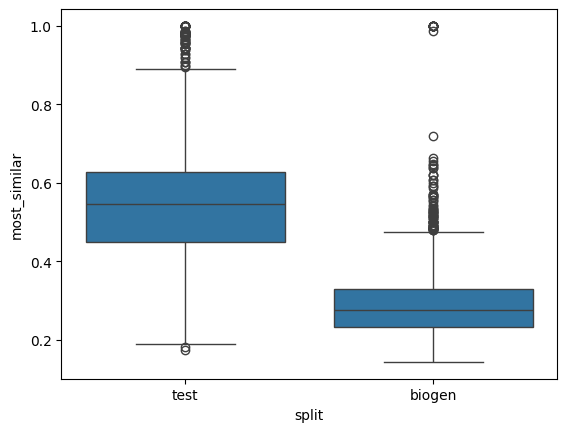

In [111]:
sns.boxplot(x="split",y="most_similar",data=pd.concat([df_test,biogen_df]))

In [112]:
iqr_test = iqr(df_test.LogS)
iqr_biogen = iqr(biogen_df.LogS)
f"test IQR = {iqr_test:.2f} Biogen IQR = {iqr_biogen:.2f}"

'test IQR = 2.59 Biogen IQR = 0.55'

In [115]:
biogen_df['pred'] = xgb.predict(np.stack(biogen_df.desc))

In [116]:
r2_score(biogen_df.LogS,biogen_df.pred)

-1.5882825088438604

<Axes: xlabel='LogS', ylabel='pred'>

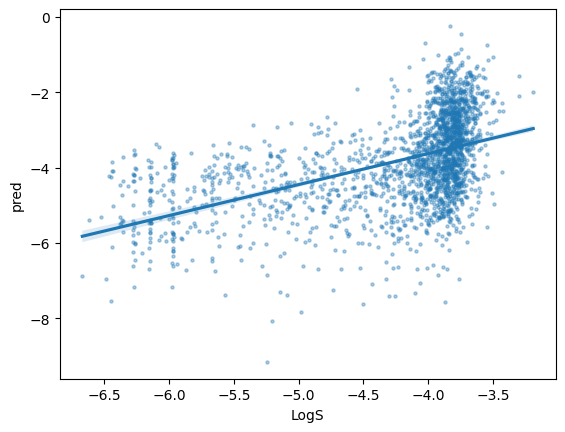

In [129]:
sns.regplot(x="LogS",y="pred",data=biogen_df,scatter_kws={"s": 5, "alpha" : 0.35})

In [130]:
mean_absolute_error(biogen_df.LogS,biogen_df.pred)

0.9217757453682749

In [163]:
antiviral_admet_ds = po.load_dataset("asap-discovery/antiviral-admet-2025-unblinded")

[2025-08-19 17:16:06] INFO     The version of Polaris that was used to create the artifact          ]8;id=329002;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=574268;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/_artifact.py#92\92]8;;\
                               (0.11.8.dev4+g40e3b2b.d20250207) is different from the currently                    
                               installed version of Polaris (0.11.10).                                             

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=361921;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=863946;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using DatasetV2.cache() for              
                               more performant data access.                                                        

[17:16:07]  Success: Fetching dataset                                                                 ]8;id=518641;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=845721;file:///opt/homebrew/Caskroom/miniforge/base/envs/rdkit_2025_03/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

In [164]:
antiviral_admet_ds.load_to_memory()

In [167]:
antiviral_admet_df = pd.DataFrame(antiviral_admet_ds.zarr_data).dropna(subset="KSOL")

In [168]:
antiviral_admet_df['LogS'] = np.log10(antiviral_admet_df.KSOL * 1e-6)

In [170]:
antiviral_admet_df['split'] = 'antiviral'

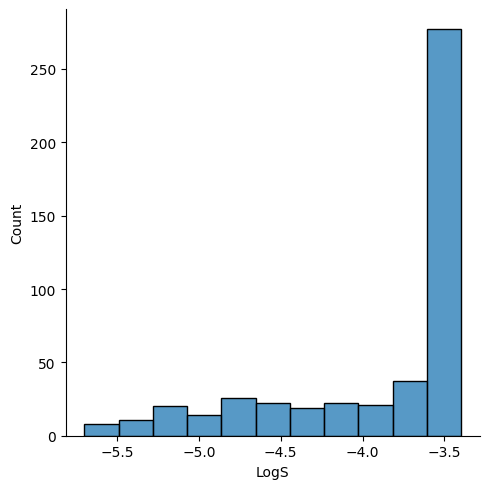

In [171]:
sns.displot(antiviral_admet_df.LogS)

<Axes: xlabel='split', ylabel='LogS'>

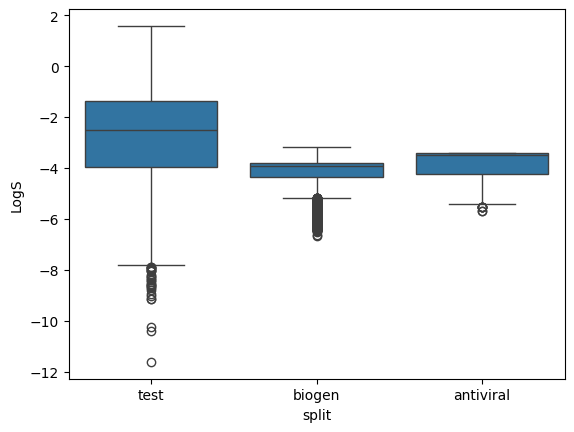

In [173]:
sns.boxplot(x="split",y="LogS",data=pd.concat([df_test,biogen_df,antiviral_admet_df]))

In [180]:
pd.DataFrame([(x.split.values[0],iqr(x.LogS)) for x in [df_test, biogen_df, antiviral_admet_df]]).round(2)

,0,1
0,test,2.59
1,biogen,0.55
2,antiviral,0.83


In [ ]:
import fastsolv
